# Combining Regularizers Analysis 

This notebook looks at the impacts of combining regularizers (i.e. for equalized odds and demographic parity) on accuracy, demographic parity gap, and equalized odds gap. This is completed for two dasets: COMPAS Recidivism (Section 1) and Adult Income (Section 2).

This code can be used to recreate the graphs in section 5.3.2 of the report. 

## 0.0 Notebook Setup

Import necessary libraries. 

In [7]:
import pandas as pd
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Uncomment this if opening in Google Drive.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.0 COMPAS

### 1.1 Load Data

In [9]:
# Load COMPAS results (exported from Weights and Biases )
dfc = pd.read_csv("/content/drive/MyDrive/Project/WB_Output/wandb_compas.csv")

In [10]:
# Trim the dataset to only include desired columns and re-order logically
dfc_trimmed = dfc[['alpha_0', 'alpha_1', 
                 'test_accuracy','test_loss', 'test_precision', 'test_recall', 
                 'train_accuracy','train_loss','train_precision', 'train_recall','train_dpd', 'train_edd', 
                 'val_accuracy', 'val_loss','val_precision', 'val_recall','val_dpd', 'val_edd']]

# Rename regularization parameters 
dfc_trimmed.columns = ['alpha_dp', 'alpha_eo', 
                      'test_accuracy','test_loss', 'test_precision', 'test_recall', 
                      'train_accuracy','train_loss','train_precision', 'train_recall','train_dpd', 'train_edd', 
                      'val_accuracy', 'val_loss','val_precision', 'val_recall','val_dpd', 'val_edd', ]

# View dataframe
dfc_trimmed.head()


,alpha_dp,alpha_eo,test_accuracy,test_loss,test_precision,test_recall,train_accuracy,train_loss,train_precision,train_recall,train_dpd,train_edd,val_accuracy,val_loss,val_precision,val_recall,val_dpd,val_edd
0,200,200,0.458362,0.980097,0.458362,1.0,0.449792,1.120745,0.449792,1.0,0.0,0.0,0.441576,1.041194,0.441576,1.0,0.0,0.0
1,200,150,0.458362,0.964303,0.458362,1.0,0.449792,1.096996,0.449792,1.0,0.0,0.0,0.441576,1.029151,0.441576,1.0,0.0,0.0
2,200,100,0.458362,0.945304,0.458362,1.0,0.449792,1.070184,0.449792,1.0,0.0,0.0,0.441576,1.015492,0.441576,1.0,0.0,0.0
3,200,50,0.458362,0.921370,0.458362,1.0,0.449792,1.038620,0.449792,1.0,0.0,0.0,0.441576,0.999249,0.441576,1.0,0.0,0.0
4,200,40,0.458362,0.915736,0.458362,1.0,0.449792,1.031485,0.449792,1.0,0.0,0.0,0.441576,0.995545,0.441576,1.0,0.0,0.0


In [11]:
# Create dataframe for training metrics 
dfc_train = dfc_trimmed[['alpha_dp', 'alpha_eo', 'train_accuracy','train_loss','train_precision', 'train_recall','train_dpd', 'train_edd']]

# Create dataframe for validation metrics
dfc_val = dfc_trimmed[['alpha_dp', 'alpha_eo', 'val_accuracy','val_loss','val_precision', 'val_recall','val_dpd', 'val_edd']]

# Create dataframe for test metrics 
dfc_test = dfc_trimmed[['alpha_dp', 'alpha_eo', 'test_accuracy','test_loss', 'test_precision', 'test_recall']]


We focus on validation results since alpha can be seen as a hyperparameter that is being tuned in pursuit of finding a "fair" model.

### 1.2 Regularizers and Accuracy

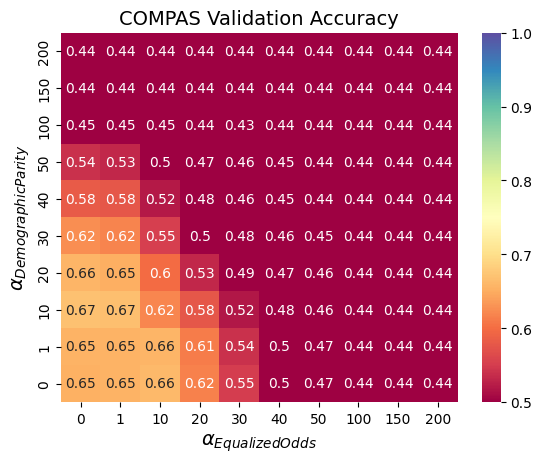

In [12]:
# Create a pivot table from the original dataframe with alpha_dp on x-axis, alpha_eo on y-axis and val_accuracy as values 
dfc_val_acc = dfc_val.pivot(index='alpha_dp',columns='alpha_eo',values='val_accuracy')

# Sort values so (0,0) is in bottom left and (200,200) is in top right
dfc_val_acc = dfc_val_acc.sort_values(by='alpha_dp',ascending=False)

# Plot heatmap 
sns.heatmap(dfc_val_acc,vmin=0.5,vmax=1,annot=True,cmap="Spectral")

# Add labels 
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.title("COMPAS Validation Accuracy",fontsize=14)
plt.show()

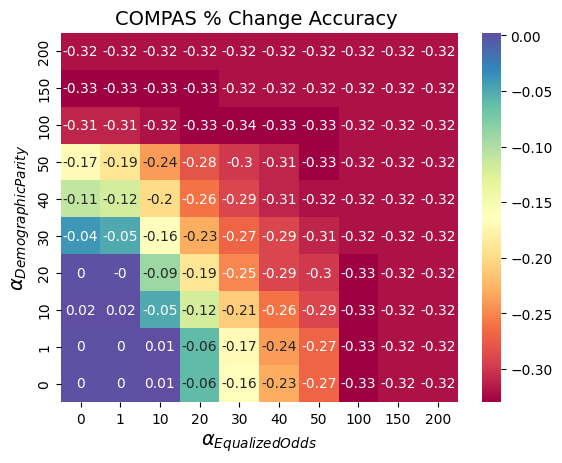

In [13]:
# Get unrounded version 
dfc_val_acc = dfc_val.pivot(index='alpha_dp',columns='alpha_eo',values='val_accuracy')
dfc_val_acc = dfc_val_acc.sort_values(by='alpha_dp',ascending=False)

# Compare to baseline 
baseline = dfc_val_acc.loc[dfc_val_acc.index==0][0].values[0]
dfc_val_acc_p = (dfc_val_acc - baseline) / baseline
dfc_val_acc_p = dfc_val_acc_p.round(2)

# Plot heatmap 
sns.heatmap(dfc_val_acc_p,vmax = 0.0025, vmin = -0.33,annot=True,cmap="Spectral")
plt.title("COMPAS % Change Accuracy ",fontsize=14)
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.show()

### 1.3 Regularizers and Demographic Parity Gap

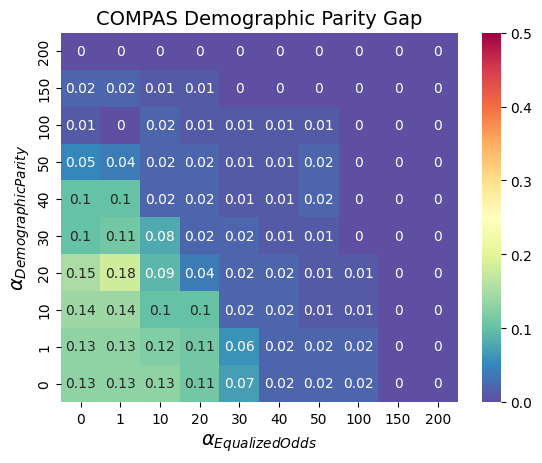

In [14]:
# Create a pivot table from the original dataframe with alpha_dp on x-axis, alpha_eo on y-axis and val_accuracy as values 
dfc_val_dpd = dfc_val.pivot(index='alpha_dp',columns='alpha_eo',values='val_dpd')

# Sort values so (0,0) is in bottom left and (200,200) is in top right
dfc_val_dpd = dfc_val_dpd.sort_values(by='alpha_dp',ascending=False).round(2)

# Plot heatmap 
sns.heatmap(dfc_val_dpd,vmin=0,vmax=0.5,annot=True,cmap="Spectral_r")
plt.title("COMPAS Demographic Parity Gap",fontsize=14)
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.show()

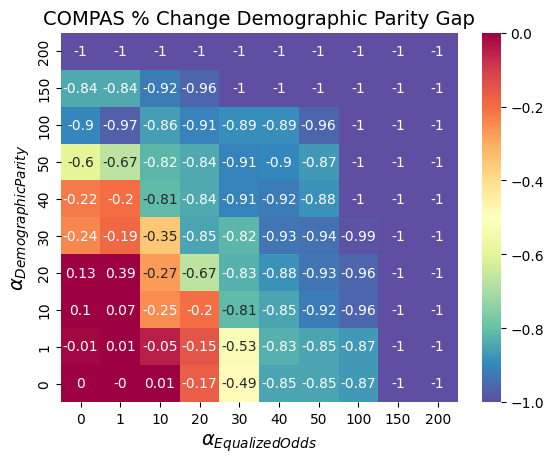

In [15]:
# Get unrounded version 
dfc_val_dpd = dfc_val.pivot(index='alpha_dp',columns='alpha_eo',values='val_dpd')
dfc_val_dpd = dfc_val_dpd.sort_values(by='alpha_dp',ascending=False)

# Get baseline and compute percentage change
baseline = dfc_val_dpd.loc[dfc_val_dpd.index==0][0].values[0]
dfc_val_dpd_p = (dfc_val_dpd - baseline) / baseline
dfc_val_dpd_p = dfc_val_dpd_p.round(2)

# Plot heatmap 
sns.heatmap(dfc_val_dpd_p,vmax = 0,vmin =-1, annot=True,cmap="Spectral_r")
plt.title("COMPAS % Change Demographic Parity Gap",fontsize=14)
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.show()

### 1.4 Regularizers and Equalized Odds Gap

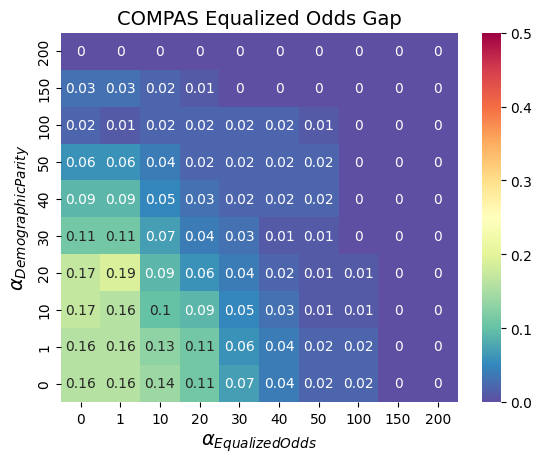

In [16]:
# Create a pivot table from the original dataframe with alpha_dp on x-axis, alpha_eo on y-axis and val_accuracy as values 
dfc_val_eod = dfc_val.pivot(index='alpha_dp',columns='alpha_eo',values='val_edd')

# Sort values so (0,0) is in bottom left and (200,200) is in top right
dfc_val_eod = dfc_val_eod.sort_values(by='alpha_dp',ascending=False).round(2)

# Plot heatmap
sns.heatmap(dfc_val_eod,vmin=0,vmax=0.5,annot=True,cmap="Spectral_r")
plt.title("COMPAS Equalized Odds Gap",fontsize=14)
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.show()

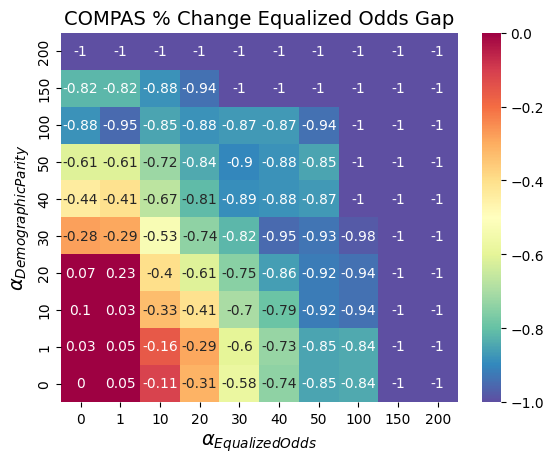

In [17]:
# Get unrounded version
dfc_val_eod = dfc_val.pivot(index='alpha_dp',columns='alpha_eo',values='val_edd')
dfc_val_eod = dfc_val_eod.sort_values(by='alpha_dp',ascending=False)

# Get baseline and compute percentage change
baseline = dfc_val_eod.loc[dfc_val_eod.index==0][0].values[0]
dfc_val_eod_p = (dfc_val_eod - baseline) / baseline
dfc_val_eod_p = dfc_val_eod_p.round(2)

# Plot heatmap 
sns.heatmap(dfc_val_eod_p,vmax = 0,vmin =-1, annot=True,cmap="Spectral_r")
plt.title("COMPAS % Change Equalized Odds Gap",fontsize=14)
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.show()

## 2.0 Adult Income

### 2.1 Load Data

In [18]:
dfa = pd.read_csv("/content/drive/MyDrive/Project/WB_Output/wandb_adult.csv")

dfa.columns 

dfa_trimmed = dfa[['alpha_0', 'alpha_1', 
                 'test_accuracy','test_loss', 'test_precision', 'test_recall', 
                 'train_accuracy','train_loss','train_precision', 'train_recall','train_dpd', 'train_edd', 
                 'val_accuracy', 'val_loss','val_precision', 'val_recall','val_dpd', 'val_edd']]

dfa_trimmed.columns = ['alpha_dp', 'alpha_eo', 
                      'test_accuracy','test_loss', 'test_precision', 'test_recall', 
                      'train_accuracy','train_loss','train_precision', 'train_recall','train_dpd', 'train_edd', 
                      'val_accuracy', 'val_loss','val_precision', 'val_recall','val_dpd', 'val_edd', ]

dfa_trimmed.head()

,alpha_dp,alpha_eo,test_accuracy,test_loss,test_precision,test_recall,train_accuracy,train_loss,train_precision,train_recall,train_dpd,train_edd,val_accuracy,val_loss,val_precision,val_recall,val_dpd,val_edd
0,200,200,0.469736,7.844428,0.478124,0.897503,0.485652,7.651412,0.495933,0.898634,0.029767,0.022083,0.460288,7.882064,0.462759,0.888742,0.029767,0.022083
1,200,150,0.475209,7.823563,0.480919,0.894218,0.490298,7.619924,0.498446,0.893422,0.031585,0.024053,0.465291,7.866355,0.465181,0.884768,0.031585,0.024053
2,200,100,0.481970,7.794710,0.484324,0.883049,0.500774,7.578842,0.504300,0.885334,0.027190,0.029415,0.475922,7.843376,0.470546,0.878146,0.027190,0.029415
3,200,50,0.507083,7.753706,0.498263,0.848226,0.518083,7.517052,0.514904,0.850647,0.040631,0.059054,0.500313,7.804977,0.483206,0.838411,0.040631,0.059054
4,200,40,0.529298,7.744113,0.512136,0.831800,0.541496,7.499957,0.530381,0.833034,0.039986,0.078621,0.532833,7.793949,0.503252,0.819868,0.039986,0.078621


In [19]:
# Create dataframe for training metrics 
dfa_train = dfa_trimmed[['alpha_dp', 'alpha_eo', 'train_accuracy','train_loss','train_precision', 'train_recall','train_dpd', 'train_edd']]

# Create dataframe for validation metrics
dfa_val = dfa_trimmed[['alpha_dp', 'alpha_eo', 'val_accuracy','val_loss','val_precision', 'val_recall','val_dpd', 'val_edd']]

# Create dataframe for test metrics 
dfa_test = dfa_trimmed[['alpha_dp', 'alpha_eo', 'test_accuracy','test_loss', 'test_precision', 'test_recall']]


### 2.2 Regularizers and Accuracy

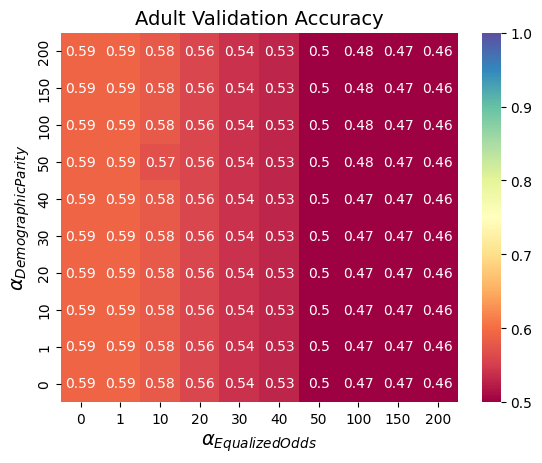

In [20]:
# Prepare data 
dfa_val_acc = dfa_val.pivot(index='alpha_dp',columns='alpha_eo',values='val_accuracy')
dfa_val_acc = dfa_val_acc.sort_values(by='alpha_dp',ascending=False).round(2)

# Plot heatmap 
sns.heatmap(dfa_val_acc,vmin=0.5,vmax=1,annot=True,cmap="Spectral")
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.title("Adult Validation Accuracy",fontsize=14)
plt.show()

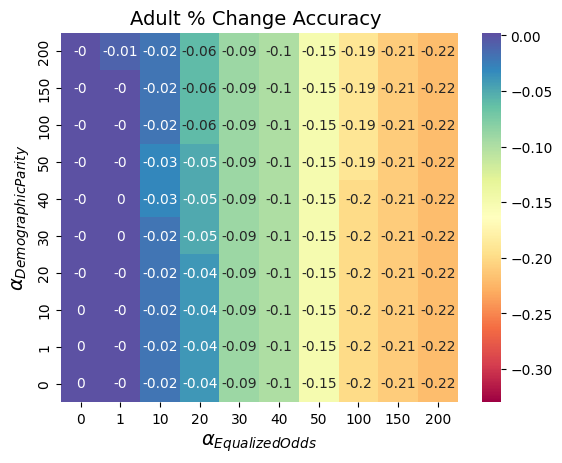

In [21]:
# Get unrounded version 
dfa_val_acc = dfa_val.pivot(index='alpha_dp',columns='alpha_eo',values='val_accuracy')
dfa_val_acc = dfa_val_acc.sort_values(by='alpha_dp',ascending=False)

# Compare to baseline 
baseline = dfa_val_acc.loc[dfa_val_acc.index==0][0].values[0]
dfa_val_acc_p = (dfa_val_acc - baseline) / baseline
dfa_val_acc_p = dfa_val_acc_p.round(2)

# Plot heatmap 
sns.heatmap(dfa_val_acc_p,vmax = 0.0025, vmin = -0.33,annot=True,cmap="Spectral")
plt.title("Adult % Change Accuracy ",fontsize=14)
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.show()

### 2.3 Regularizers and Demographic Parity Gap

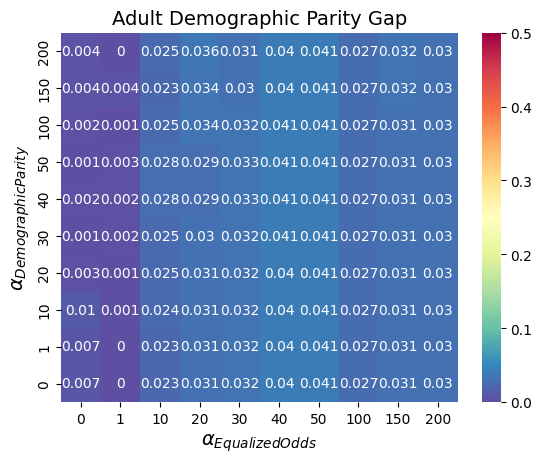

In [22]:
# Prepare Data 
dfa_val_dpd = dfa_val.pivot(index='alpha_dp',columns='alpha_eo',values='val_dpd')
dfa_val_dpd = dfa_val_dpd.sort_values(by='alpha_dp',ascending=False).round(3)

# Plot Heatmap
sns.heatmap(dfa_val_dpd,vmin=0,vmax=0.5,annot=True,cmap="Spectral_r")
plt.title("Adult Demographic Parity Gap",fontsize=14)
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.show()



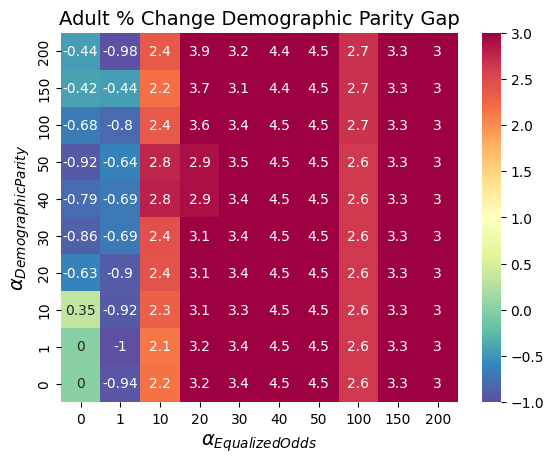

In [23]:
# Get unrounded version 
dfa_val_dpd = dfa_val.pivot(index='alpha_dp',columns='alpha_eo',values='val_dpd')
dfa_val_dpd = dfa_val_dpd.sort_values(by='alpha_dp',ascending=False)

# Get baseline and compute percentage change
baseline = dfa_val_dpd.loc[dfa_val_dpd.index==0][0].values[0]
dfa_val_dpd_p = (dfa_val_dpd - baseline) / baseline
dfa_val_dpd_p = dfa_val_dpd_p.round(2)

# Plot heatmap 
sns.heatmap(dfa_val_dpd_p,vmax = 3,vmin =-1, annot=True,cmap="Spectral_r")
plt.title("Adult % Change Demographic Parity Gap",fontsize=14)
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.show()

### 2.4 Regularizers and Equalized Odds Gap

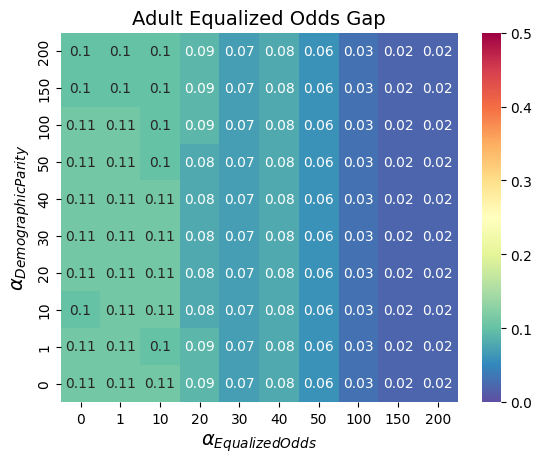

In [24]:
# Prepare Data
dfa_val_eod = dfa_val.pivot(index='alpha_dp',columns='alpha_eo',values='val_edd')
dfa_val_eod = dfa_val_eod.sort_values(by='alpha_dp',ascending=False).round(2)

# Plot Heatmap 
sns.heatmap(dfa_val_eod,vmin=0,vmax=0.5,annot=True,cmap="Spectral_r")
plt.title("Adult Equalized Odds Gap",fontsize=14)
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.show()

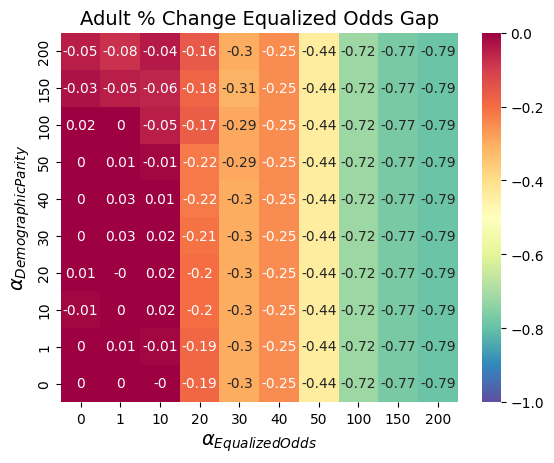

In [25]:
# Get unrounded version
dfa_val_eod = dfa_val.pivot(index='alpha_dp',columns='alpha_eo',values='val_edd')
dfa_val_eod = dfa_val_eod.sort_values(by='alpha_dp',ascending=False)

# Get baseline and compute percentage change
baseline = dfa_val_eod.loc[dfc_val_eod.index==0][0].values[0]
dfa_val_eod_p = (dfa_val_eod - baseline) / baseline
dfa_val_eod_p = dfa_val_eod_p.round(2)

# Plot heatmap 
sns.heatmap(dfa_val_eod_p,vmax = 0,vmin =-1, annot=True,cmap="Spectral_r")
plt.title("Adult % Change Equalized Odds Gap",fontsize=14)
plt.xlabel(r"$\alpha_{Equalized Odds}$",fontsize=14)
plt.ylabel(r"$\alpha_{Demographic Parity}$",fontsize=14)
plt.show()

## 3.0 Trivial Classifiers and Fairness

When a model only predicts in one class, then 
$\forall a \in A$ : 

$P(h(x) | A=a) = P(h(x)) = 0 $

Demographic parity will always be achieved when uniformly predicting a single class. 

Also $\forall a \in A, \forall y \in Y$ : 

$P(h(x) | A=a, Y=y) = P(h(x)) = 0 $

Equalized odds will always be achieved when uniformly predicting a single class. 

Thus, regularizing may only further incentivize the model to take this approach and predict uniformly.



In [26]:
!pip install fairlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio, demographic_parity_difference, equalized_odds_difference

def dpd(prediction, true, sensitive_features):
  return demographic_parity_difference(true,prediction, sensitive_features=sensitive_features)


def eod(prediction, true, sensitive_features):
  return equalized_odds_difference(true,prediction, sensitive_features=sensitive_features)

Below is a test case of a trivial binary classifier that always predicts the positive class (i.e. 1), regardless of the true target. We can see that both the demographic parity and equalized odds gaps are zero.

In [28]:
h = np.ones(100)
y = np.random.rand(100) * 0.2
y = y.round()
a = np.zeros(100)
a[:50] = np.ones(50)

print ("Demographic Parity Difference", dpd(h,y,a))
print ("Equalized Odds Difference", eod(h,y,a))

Demographic Parity Difference 0.0
Equalized Odds Difference 0.0


Below is a test case of a trivial binary classifier that always predicts the negative class (i.e. 0), regardless of the true target. We can see that both the demographic parity and equalized odds gaps are zero.

In [29]:
h = np.zeros(100)
y = np.random.rand(100) * 0.2
y = y.round()
a = np.zeros(100)
a[:50] = np.ones(50)

print ("Demographic Parity Difference", dpd(h,y,a))
print ("Equalized Odds Difference", eod(h,y,a))

Demographic Parity Difference 0.0
Equalized Odds Difference 0.0
